
 For q = 2: (acc: 96.726)
    0    1
0  97   11
1   0  228

 For q = 4: (acc: 97.321)
    0    1
0  99    9
1   0  228

 For q = 8: (acc: 94.643)
    0    1
0  90   18
1   0  228

 For q = 16: (acc: 92.262)
    0    1
0  82   26
1   0  228


Length   0.549895695372345
Diameter   0.5661313558092049
Height   0.5437468820293492
Whole weight   0.5348149352505281
Shucked weight   0.4139103486531266
Viscera weight   0.4991665124527933
Shell weight   0.6250188056939961


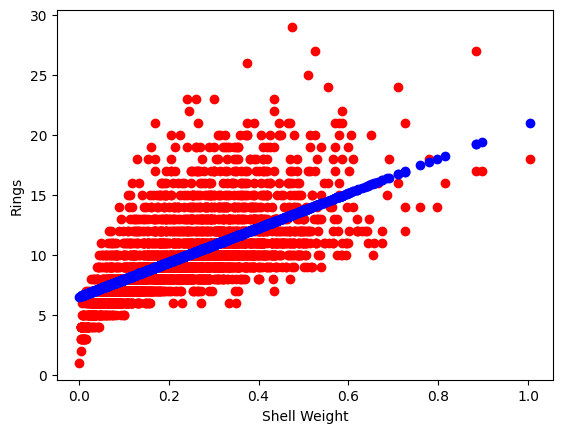

2.5278463391347246
2.467940147010543


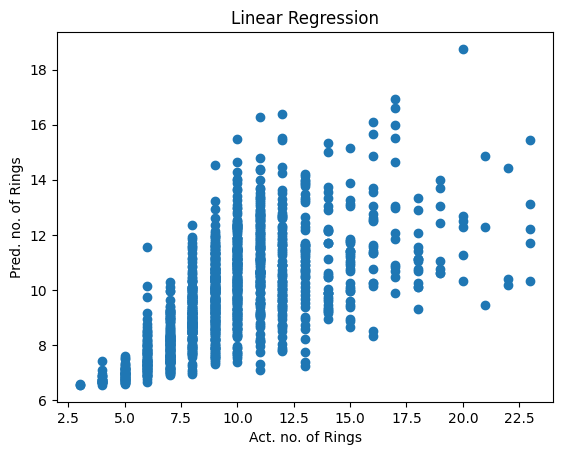


2.216182487730409
2.2192193506637916


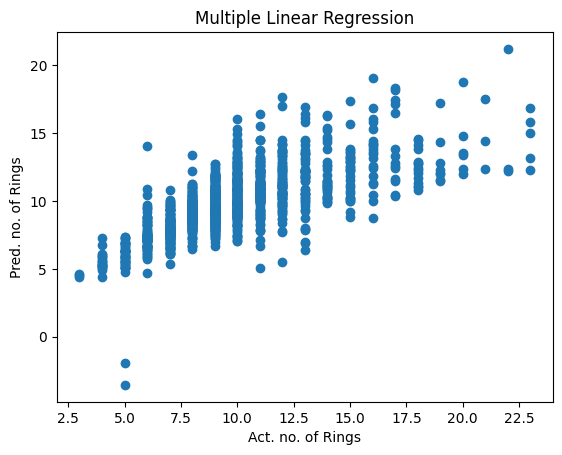

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Reading the file
df = pd.read_csv('abalone.csv')

####################################################################

#  PART A

# Reading the Files
train_data = pd.read_csv('SteelPlateFaults-train.csv')
test_data = pd.read_csv('SteelPlateFaults-test.csv')

train_data = train_data.drop(["TypeOfSteel_A400", "TypeOfSteel_A300", "Y_Minimum", "X_Minimum"], axis=1)
test_data = test_data.drop(["TypeOfSteel_A400", "TypeOfSteel_A300", "Y_Minimum", "X_Minimum"], axis=1)

test_data2 = test_data.pop('Class')

# Building Separate Classes for GMM
train_class_1 = train_data[train_data['Class'] == 1]
train_class_1 = train_class_1.drop('Class', axis=1)

train_class_0 = train_data[train_data['Class'] == 0]
train_class_0 = train_class_0.drop('Class', axis=1)

# Computing the prior probability 
p0 = train_class_0.shape[0] / (train_class_0.shape[0] + train_class_1.shape[0])
p1 = train_class_1.shape[0] / (train_class_0.shape[0] + train_class_1.shape[0])

li = [2, 4, 8, 16]
for q in li:
    # fitting the model for class0 and class1 for Q=q
    GMM0 = GaussianMixture(n_components=q, covariance_type='full', random_state=42, reg_covar=1e-4).fit(train_class_0)
    GMM1 = GaussianMixture(n_components=q, covariance_type='full', random_state=42, reg_covar=1e-4).fit(train_class_1)
    
    # List to store the predicted class 
    res = [] 
    for _, test_sample in test_data.iterrows():  # Iterating over each test sample
        # Converting the test sample to DataFrame to maintain feature names
        test_sample_df = pd.DataFrame([test_sample])

        # Computing likelihood probability
        logliklehood_0 = GMM0.score_samples(test_sample_df)[0]
        logliklehood_1 = GMM1.score_samples(test_sample_df)[0]
        liklehood_0 = np.exp(logliklehood_0)
        liklehood_1 = np.exp(logliklehood_1)

        # If P(X/C0)*P(C0) > P(X/C1)*P(C1), sample is of class 0 as per Bayes classifier
        if (p0 * liklehood_0 > p1 * liklehood_1):
            res.append(0)
        else:
            res.append(1)

    acc_score = (res == test_data2.values).sum() / test_data2.shape[0]

    print(f"\n For q = {q}: (acc: {100 * acc_score:.3f})")
    # The Confusion Matrix
    mat = confusion_matrix(test_data2, res)
    mat = pd.DataFrame(mat, index=[0, 1], columns=[0, 1])
    print(mat)
print()

####################################################################

#  PART B
X = df.copy()
Y = df['Rings']

# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)
X_train.to_csv('abalone-train.csv', index=False)
X_test.to_csv('abalone-test.csv', index=False)

# 1st Task
print()
d1 = pd.read_csv('abalone-train.csv')
d2 = pd.read_csv('abalone-test.csv')
a = []  # Stores name for all the attributes except 'Rings'
b = []  # Stores correlation coefficient of all attributes with 'Rings'

for i in d1.columns:
    if i != 'Rings':
        b.append(d1['Rings'].corr(d1[i]))
        a.append(i)
        print(i, " ", d1['Rings'].corr(d1[i]))

# After observing the above dataframe it is evident that 'Shell weight' has maximum correlation with 'Rings'

p_f = PolynomialFeatures(1)
train_p = p_f.fit_transform(np.array(X_train['Shell weight']).reshape(-1, 1))
test_p = p_f.fit_transform(np.array(X_test['Shell weight']).reshape(-1, 1))
LR = LinearRegression()
LR.fit(train_p, np.array(Y_train).reshape(-1, 1))
train_predicted = LR.predict(train_p)
test_predicted = LR.predict(test_p)
plt.scatter(X_train['Shell weight'], Y_train, color='red')
plt.scatter(np.array(X_train['Shell weight']).reshape(-1, 1), train_predicted, color='blue')  # plotting best fit line on training data
plt.ylabel('Rings')
plt.xlabel('Shell Weight')
plt.show()

# Calculating the mean squared errors
mse_train = mean_squared_error(np.array(Y_train).reshape(-1, 1), train_predicted)
print(np.sqrt(mse_train))

mse_test = mean_squared_error(np.array(Y_test).reshape(-1, 1), test_predicted)
print(np.sqrt(mse_test))

plt.scatter(np.array(Y_test).reshape(-1, 1), test_predicted)
plt.ylabel('Pred. no. of Rings')
plt.xlabel('Act. no. of Rings')
plt.title("Linear Regression")
plt.show()

# 2nd Task
print()
d1 = d1.drop('Rings', axis=1)
d2 = d2.drop('Rings', axis=1)
p_f = PolynomialFeatures(1)
train_p = p_f.fit_transform(np.array(d1))
test_p = p_f.fit_transform(np.array(d2))
LR = LinearRegression()
LR.fit(train_p, np.array(Y_train).reshape(-1, 1))
train_predicted = LR.predict(train_p)
test_predicted = LR.predict(test_p)
mse_train = mean_squared_error(np.array(Y_train).reshape(-1, 1), train_predicted)
mse_test = mean_squared_error(np.array(Y_test).reshape(-1, 1), test_predicted)
print(np.sqrt(mse_train))
print(np.sqrt(mse_test))
plt.scatter(np.array(Y_test).reshape(-1, 1), test_predicted)  # plotting the actual vs predicted rings on test data
plt.ylabel('Pred. no. of Rings')
plt.xlabel('Act. no. of Rings')
plt.title("Multiple Linear Regression")
plt.show()

# 3rd Task
print()  # As 'Shell weight' has maximum correlation with 'Rings' so it is used as input as given below with varying P as we use simple polynomial regression

def fn3():
    l1 = []  # Stores the rmse error for different values of P on training data
    l2 = []  # Stores the rmse error for different values of P on test data
    l3 = []  # Stores the value of P
    for p in range(2, 6):
        p_f = PolynomialFeatures(p)
        train_p = p_f.fit_transform(np.array(X_train['Shell weight']).reshape(-1, 1))
        test_p = p_f.fit_transform(np.array(X_test['Shell weight']).reshape(-1, 1))
        LR = LinearRegression()
        LR.fit(train_p, np.array(Y_train).reshape(-1, 1))
        train_predicted = LR.predict(train_p)
        test_predicted = LR.predict(test_p)
        mse_train = mean_squared_error(np.array(Y_train).reshape(-1, 1), train_predicted)
        mse_test = mean_squared_error(np.array(Y_test).reshape(-1, 1), test_predicted)
        l1.append(np.sqrt(mse_train))
        l2.append(np.sqrt(mse_test))
        l3.append(p)
    plt.bar(l3, l1)
    plt.ylabel('RMSE')
    plt.xlabel('p')
    plt.title("Prediction accuracy")
    plt.show()
    plt.bar(l3, l2)
    plt.ylabel('RMSE')
    plt.xlabel('p')
    plt.title("Prediction accuracy")
    plt.show()
    print(l1)
    print(l2)
    index = 0
    a = l2[0]
    for i in range(len(l2)):
        if (l2[i] < a):
            index = i
            a = l2[i]
    print(l3[index])
    p_f = PolynomialFeatures(l3[index])
    train_p = p_f.fit_transform
